## Paper Reading Analysis - Code Implementation
### Statistics of the the Models Evaluation and Examining Commonly Misclassified Images
### Jonathan Alcineus

In [1]:
# These handle the file locations and importing the dataframe from the saved datafile from the authors files
import os
import pandas as pd


# These handle the image processing, editing, or displaying that needs to be performed
import cv2 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import skimage

# These handle training the convolutional neural network (CNN) model
import tensorflow as tf
import keras
import numpy as np
import sklearn
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD

import copy

2025-09-02 03:11:00.934292: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 03:11:03.232307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756782663.867621    3343 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756782664.078030    3343 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756782665.176218    3343 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:

# This changes the home directory
home_directory = os.path.expanduser("~")
os.chdir(home_directory)

# Then goes to the folder where the data lies
os.chdir('DNNorDermatologist')

# Ensures that we are in the correct folder
print(os.getcwd())

# Open the dataframe for the photos that are in the zip file
loaded_df = pd.read_pickle('NvAndMelNoDuplicatesFullSize.zip')


/teamspace/studios/this_studio/DNNorDermatologist


In [3]:
# GradCAM and Kernel SHAP Experiments
os.chdir(home_directory)
os.chdir('paper-reading-analysis')

# Library with the methods that I needed
import gradcam_shap
import scipy

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.chdir(home_directory)
os.chdir('DNNorDermatologist')
os.chdir('DataSplitted')
seed = 0
model = load_model(f'inception_saved_trial_{seed}.keras')

I0000 00:00:1756761174.254698  156660 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13949 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [5]:
import collections
import collections.abc
collections.Iterable = collections.abc.Iterable

from vis.utils import utils
from keras import layers, activations

#Assorted modifications for model compatibility with gradCAM
gmodel = copy.deepcopy(model)

print(gmodel.layers)

layer_idx = utils.find_layer_idx(gmodel,'dense_1')

#swap with softmax with linear classifier for the reasons mentioned above
gmodel.layers[layer_idx].activation = activations.linear
gmodel = utils.apply_modifications(gmodel)

[<InputLayer name=input_layer, built=True>, <Conv2D name=conv2d, built=True>, <BatchNormalization name=batch_normalization, built=True>, <Activation name=activation, built=True>, <Conv2D name=conv2d_1, built=True>, <BatchNormalization name=batch_normalization_1, built=True>, <Activation name=activation_1, built=True>, <Conv2D name=conv2d_2, built=True>, <BatchNormalization name=batch_normalization_2, built=True>, <Activation name=activation_2, built=True>, <MaxPooling2D name=max_pooling2d, built=True>, <Conv2D name=conv2d_3, built=True>, <BatchNormalization name=batch_normalization_3, built=True>, <Activation name=activation_3, built=True>, <Conv2D name=conv2d_4, built=True>, <BatchNormalization name=batch_normalization_4, built=True>, <Activation name=activation_4, built=True>, <MaxPooling2D name=max_pooling2d_1, built=True>, <Conv2D name=conv2d_8, built=True>, <BatchNormalization name=batch_normalization_8, built=True>, <Activation name=activation_8, built=True>, <Conv2D name=conv2d_

In [10]:
os.chdir(home_directory)
os.chdir('paper-reading-analysis')
%run gradcam_shap.py

/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
os.chdir(home_directory)
os.chdir('DNNorDermatologist')

# Get the test dataset of 400 - 200 nevi and 200 melanoma
test_df = pd.read_pickle('NvAndMelNoDuplicatesFullSizeTestSet.zip')

# Change the idx column to be '0' where the diagnosis of the lesion was
# nevi, and '1' when the diagnosis is diagnosis
test_df['idx'] = np.where(test_df['id'] == 'mel', 1 , 0)

# Save a new table 'features' to be test_df, without the idx column
features=test_df.drop(columns=['idx'], axis = 1)
# Create a new table with just the correct diagnosis (0 for melanoma (or nevi), 1 for nevi (or melanoma))
target=test_df['idx']

# Change features to be a numpy array of image pixel data ((R, G, B))
features = np.asarray(features['image'].tolist())

# I want to resize the images 
features = np.array([cv2.resize(image, (224, 224)) for image in features])

# Normalise this data in an alternate table to be values from 0 ... 1
# e.g. 255 -> 1, 0 --> 0
# Normalises for original prediction and evaluation of model, the SHAP funciton below requires non normalised data
# TODO: Standarise this so SHAP takes normalised

features2 = features / 255

# Convert the data to one-hot encoding
target_cat = to_categorical(target, num_classes = 2)

# Get predictions for image data
# e.g.
# Index 0 : [0.9222, 0.0778]
# Index 1 : [0.4500, 0.5500]
# etc..
# This represents likelihood of melanoma and nevi respectively (according to the model)
y_pred = model.predict(features2, verbose=1)
y_pred = [[value[0], 1-value[0]] for value in y_pred]

print(y_pred)

# Create a new dataframe with entries for each element of the test set
# Include an ID, diagnosis, and % likelihoods for each diagnosis from the model
df = pd.DataFrame(columns=['ID', 'Dx', '% Mel', '% Nev'],index=[i for i in range(400)])
df['ID'] = df.index

# Create dictionaries to contain actual diagnosis and probabilities from the model
dx_d = {}
Pmel = {}
Pnev = {}
# Take the actual diagnoses from where we retrieved them earlier
y_test_cat = target_cat

# For each element in the test set:
for ind in range(400):
    # Append the diagnosis and predictions to their respective dictionaries
    if y_test_cat[ind][1] == 1.0:
        diagnosis = 'Melanoma'
    elif y_test_cat[ind][0] == 1.0:
        diagnosis = 'Nevus'
    dx_d[ind] = diagnosis
    Pmel[ind] = y_pred[ind][0]
    Pnev[ind] = y_pred[ind][1]
    
# Take the above dictionaries and insert them into the data frame
df['Dx'] = df['ID'].map(dx_d)
df['% Mel'] = df['ID'].map(Pmel)
df['% Nev'] = df['ID'].map(Pnev)

# Change the prediction likelihoods to be floats 
df = df.astype({"% Mel": float, "% Nev": float})

#df = df.iloc[id_list]

# Print the first 5 entries in the data frame
print('Unseen set') 
print(df)

I0000 00:00:1756761194.084970  157855 service.cc:152] XLA service 0x7f649c0042b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756761194.084998  157855 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-09-01 21:13:14.205191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1756761195.485851  157855 cuda_dnn.cc:529] Loaded cuDNN version 91200


 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

I0000 00:00:1756761201.384563  157855 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 762ms/step
[[np.float32(0.94769686), np.float32(0.052303135)], [np.float32(0.42241505), np.float32(0.577585)], [np.float32(0.999094), np.float32(0.0009059906)], [np.float32(0.6896515), np.float32(0.3103485)], [np.float32(0.3725057), np.float32(0.62749434)], [np.float32(0.9998692), np.float32(0.00013077259)], [np.float32(0.9886247), np.float32(0.011375308)], [np.float32(0.9066825), np.float32(0.09331751)], [np.float32(0.99392205), np.float32(0.006077945)], [np.float32(0.767272), np.float32(0.232728)], [np.float32(0.99961543), np.float32(0.00038456917)], [np.float32(0.8586497), np.float32(0.14135033)], [np.float32(1.0), np.float32(0.0)], [np.float32(0.9601376), np.float32(0.039862394)], [np.float32(0.7989191), np.float32(0.20108092)], [np.float32(0.71827865), np.float32(0.28172135)], [np.float32(0.94368005), np.float32(0.056319952)], [np.float32(0.26373613), np.float32(0.7362639)], [np.float32(0.89186686), np.float32(0.10813314)], [np.float32(0.97835857), n

In [7]:
# I want examine the results, so I will just save them
df.to_csv(f'predictions_model_{seed}.csv')

In [26]:
# We need to count the number of false posistives (nevi classified as melanoma)and false negatives (melanoma as nevi)
misclassifications = []
num_of_models = 15

os.chdir(home_directory)
os.chdir('paper-reading-analysis')


for i in range(num_of_models):
    model_df = pd.read_csv(f'predictions_model_{i}.csv')
    fals_pos = []
    fals_neg = []
    for idx, row in model_df.iterrows():
        if row['Dx'] == 'Nevus' and row['% Mel'] > 0.5:
            fals_pos.append(row['ID'])
        if row['Dx'] == 'Melanoma' and row['% Nev'] > 0.5:
            fals_neg.append(row['ID'])
    misclassifications.append({'fals_pos':fals_pos, 'fals_neg': fals_neg})
    
# After counting the number of false postives and false negative that every model has classified
# I need display the number of misclassifcations for each model
nums_of_fals_pos = []
nums_of_fals_neg = []

for i in range(num_of_models):
    print(f'(Model {i}) \nnumber of nevi classified as melanoma: {len(misclassifications[i]["fals_pos"])}')
    print(f'number of melanoma classified as nevi: {len(misclassifications[i]["fals_neg"])}')
    nums_of_fals_pos.append(len(misclassifications[i]["fals_pos"]))
    nums_of_fals_neg.append(len(misclassifications[i]["fals_neg"]))



(Model 0) 
number of nevi classified as melanoma: 9
number of melanoma classified as nevi: 45
(Model 1) 
number of nevi classified as melanoma: 26
number of melanoma classified as nevi: 22
(Model 2) 
number of nevi classified as melanoma: 19
number of melanoma classified as nevi: 31
(Model 3) 
number of nevi classified as melanoma: 19
number of melanoma classified as nevi: 30
(Model 4) 
number of nevi classified as melanoma: 16
number of melanoma classified as nevi: 33
(Model 5) 
number of nevi classified as melanoma: 18
number of melanoma classified as nevi: 21
(Model 6) 
number of nevi classified as melanoma: 14
number of melanoma classified as nevi: 33
(Model 7) 
number of nevi classified as melanoma: 26
number of melanoma classified as nevi: 26
(Model 8) 
number of nevi classified as melanoma: 26
number of melanoma classified as nevi: 16
(Model 9) 
number of nevi classified as melanoma: 7
number of melanoma classified as nevi: 35
(Model 10) 
number of nevi classified as melanoma: 2

In [10]:
import statistics

print(f"The average number of nevi classified as melanoma: {statistics.mean(nums_of_fals_pos)}")
print(f"The average number of melanoma classified as nevi: {statistics.mean(nums_of_fals_neg)}")

print(f"The standard deviation for the number of nevi classified as melanoma: {statistics.stdev(nums_of_fals_pos)}")
print(f"The standard deviation for the number of melanoma classified as nevi: {statistics.stdev(nums_of_fals_neg)}")

The average number of nevi classified as melanoma: 20.2
The average number of melanoma classified as nevi: 29.266666666666666
The standard deviation for the number of nevi classified as melanoma: 6.81594768591594
The standard deviation for the number of melanoma classified as nevi: 9.215411522216982


In [61]:
from collections import Counter

entire_fals_pos_list = [] # To find the top ten indices that have been classified as melanoma when their are nevi
entire_fals_neg_list = [] # To find the top ten indices that have been classified as nevi when their are melanoma

for i in range(num_of_models):
    for item in misclassifications[i]['fals_pos']:
        entire_fals_pos_list.append(item)
    for item in misclassifications[i]['fals_neg']:
        entire_fals_neg_list.append(item)

print("Ten most commonly missclassified as melanoma images")
print(Counter(entire_fals_pos_list))

print("Ten most commonly missclassified as nevi images")
print(Counter(entire_fals_neg_list))



Ten most commonly missclassified as melanoma images
Counter({228: 14, 231: 13, 230: 12, 213: 11, 285: 11, 211: 10, 226: 10, 270: 10, 247: 9, 321: 9, 344: 9, 383: 9, 372: 9, 375: 8, 342: 8, 304: 8, 234: 8, 263: 7, 206: 7, 258: 7, 259: 6, 376: 6, 323: 6, 222: 5, 345: 5, 245: 5, 316: 5, 389: 5, 380: 5, 362: 4, 359: 4, 271: 3, 272: 3, 310: 3, 254: 3, 350: 3, 368: 3, 203: 3, 225: 3, 351: 3, 212: 2, 218: 2, 349: 2, 355: 2, 360: 2, 280: 2, 393: 2, 233: 2, 274: 2, 242: 1, 282: 1, 240: 1, 261: 1, 334: 1, 322: 1, 336: 1, 223: 1, 340: 1, 353: 1, 364: 1, 386: 1, 377: 1})
Ten most commonly missclassified as nevi images
Counter({57: 15, 21: 14, 117: 14, 62: 13, 67: 13, 130: 13, 151: 13, 23: 12, 91: 11, 105: 11, 197: 11, 163: 10, 185: 10, 28: 9, 153: 9, 168: 9, 77: 8, 110: 8, 150: 8, 171: 8, 15: 8, 34: 8, 47: 7, 84: 7, 187: 7, 179: 7, 43: 7, 82: 6, 95: 6, 139: 6, 93: 6, 51: 6, 4: 5, 26: 5, 60: 5, 81: 5, 90: 5, 190: 5, 180: 5, 20: 4, 111: 4, 119: 4, 137: 4, 173: 4, 53: 3, 69: 3, 33: 3, 165: 3, 19: 3, 

In [13]:
# The indeces of the images of nevi that has been misclassified as melanoma by all models
fals_pos_all_indeces = list(set(misclassifications[0]['fals_pos']) & set(misclassifications[1]['fals_pos']) &
set(misclassifications[2]['fals_pos']) & set(misclassifications[3]['fals_pos']) & set(misclassifications[4]['fals_pos']) &
set(misclassifications[5]['fals_pos']) & set(misclassifications[6]['fals_pos']) & set(misclassifications[7]['fals_pos']) &
set(misclassifications[8]['fals_pos']) & set(misclassifications[9]['fals_pos']) & set(misclassifications[10]['fals_pos']) &
set(misclassifications[11]['fals_pos']) & set(misclassifications[12]['fals_pos']) & set(misclassifications[13]['fals_pos']) &
set(misclassifications[14]['fals_pos'])
)

print(fals_pos_all_indeces)

[]


In [13]:
fals_neg_all_indeces = list(set(misclassifications[0]['fals_neg']) & set(misclassifications[1]['fals_neg']) &
set(misclassifications[2]['fals_neg']) & set(misclassifications[3]['fals_neg']) & set(misclassifications[4]['fals_neg']) &
set(misclassifications[5]['fals_neg']) & set(misclassifications[6]['fals_neg']) & set(misclassifications[7]['fals_neg']) &
set(misclassifications[8]['fals_neg']) & set(misclassifications[9]['fals_neg']) & set(misclassifications[10]['fals_neg']) &
set(misclassifications[11]['fals_neg']) & set(misclassifications[12]['fals_neg']) & set(misclassifications[13]['fals_neg']) &
set(misclassifications[14]['fals_neg'])
)

print(fals_neg_all_indeces)

[57]


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step


100%|██████████| 1/1 [00:48<00:00, 48.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[0.         0.         0.08552381 0.         0.0493575  0.
 0.         0.         0.         0.         0.02379124 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.03384186 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05247157 0.         0.        

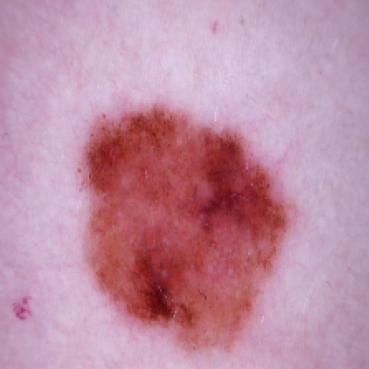

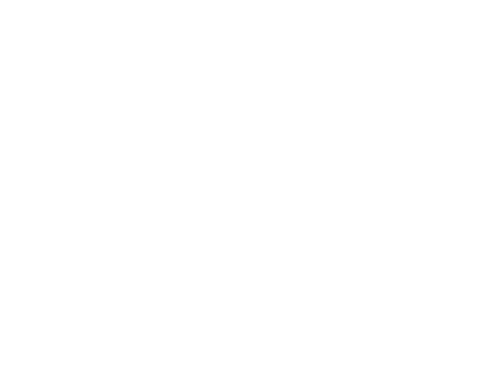

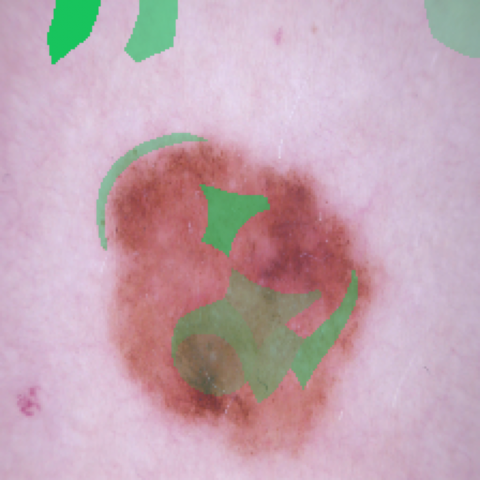

<Figure size 640x480 with 0 Axes>

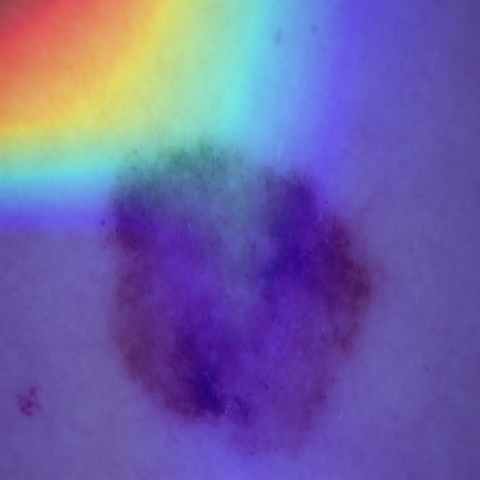

In [9]:
# Examining image with 228, nevus missclassified as melanoma
# I am looking at the results of the image, along with the maps for GradCAM and kernel SHAP

plt.imshow(features[228])
plt.axis('off')
Shap_single(features[228], model, gmodel, save = False, filename = None, relative_path = None)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


100%|██████████| 1/1 [00:27<00:00, 27.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.03537404  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.05832609  0.          0.          0.
  0.          0.          0.06091503  0.          0.         

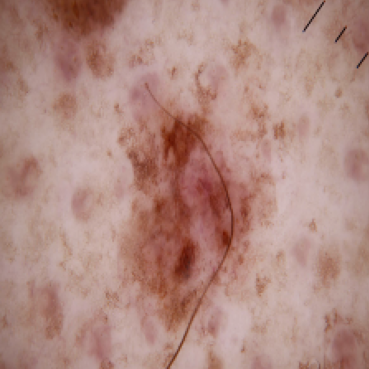

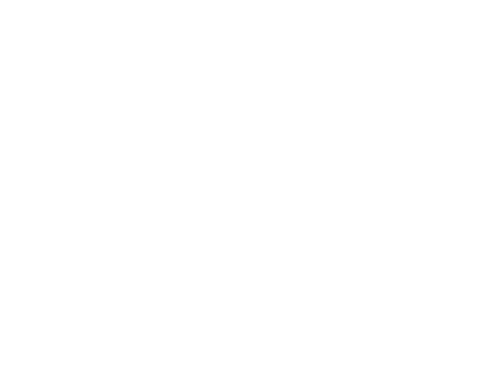

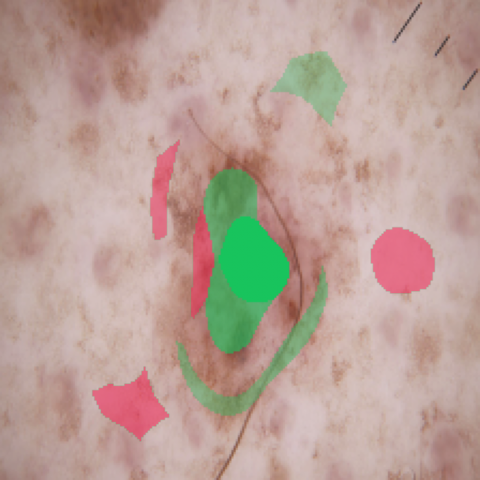

<Figure size 640x480 with 0 Axes>

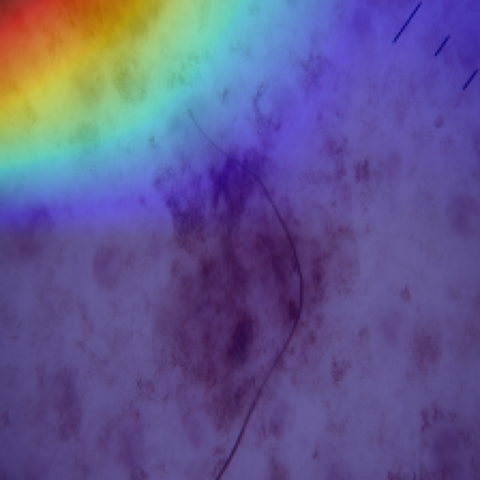

In [10]:
plt.imshow(features[231])
plt.axis('off')
Shap_single(features[231], model, gmodel, save = False, filename = None, relative_path = None)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


100%|██████████| 1/1 [00:25<00:00, 25.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.          0.          0.          0.          0.08315357
  0.          0.         -0.00878263  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.0

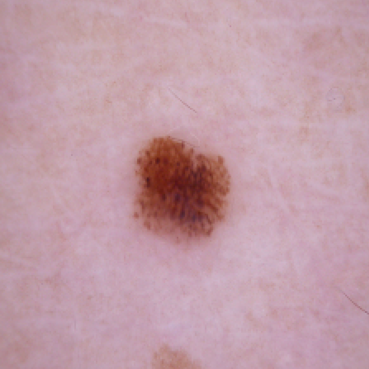

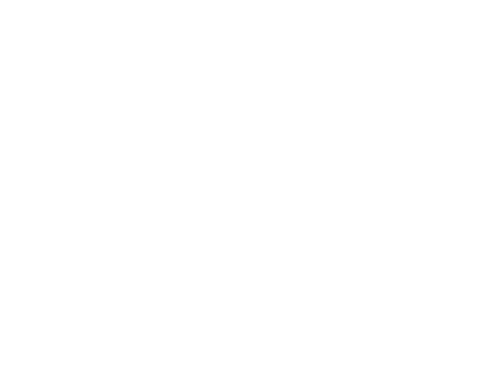

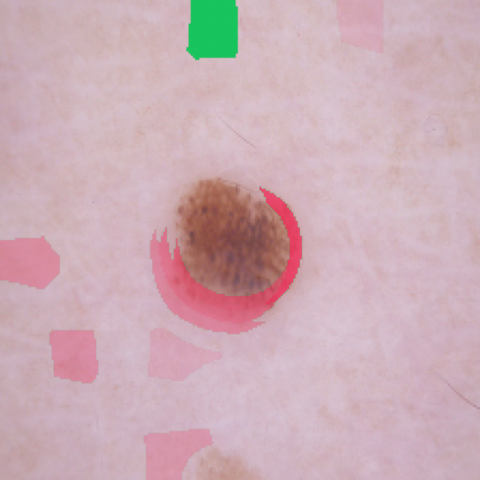

<Figure size 640x480 with 0 Axes>

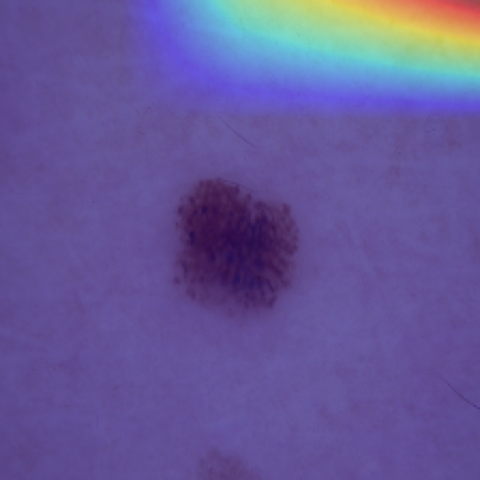

In [11]:
plt.imshow(features[57])
plt.axis('off')
Shap_single(features[57], model, gmodel, save = False, filename = None, relative_path = None)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


100%|██████████| 1/1 [00:26<00:00, 26.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.03836484  0.         -0.02807995  0.         -0.00780401  0.
  0.          0.         -0.01156023  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         

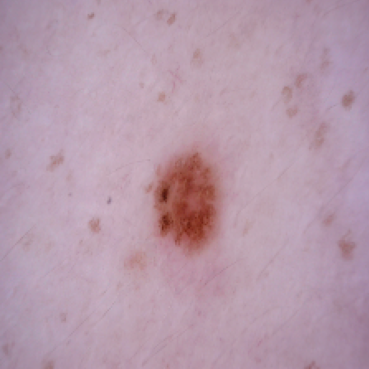

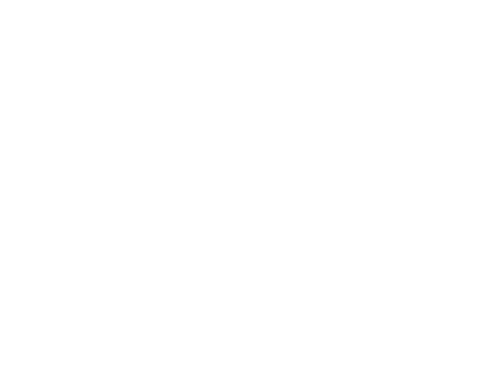

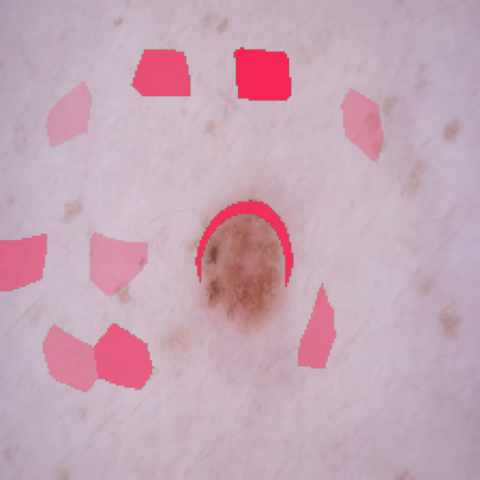

<Figure size 640x480 with 0 Axes>

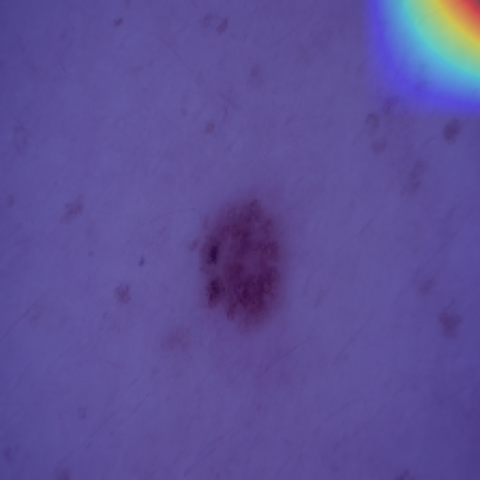

In [12]:
plt.imshow(features[21])
plt.axis('off')
Shap_single(features[21], model, gmodel, save = False, filename = None, relative_path = None)